# Kaplan-Meier Analysis for Overall Survival (OS)

In [1]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

os.chdir('../../')
os.getcwd()

'd:\\Work\\Non PT\\Data Science\\BG\\mcrc-cetuximab-analysis'

## Prepare Data

In [2]:
ann = pd.read_csv("raw/ann_PRJNA805525.csv")

In [5]:
# Prepare data for OS analysis
km_df = ann[['CMS_predicted', 'OS', 'OS_FLAG']].dropna()

# Rename and convert OS from days to months
km_df = km_df.rename(columns={
    'CMS_predicted': 'CMS',
    'OS': 'survival_time',
    'OS_FLAG': 'event'
})
km_df['survival_time'] = km_df['survival_time'] / 30.44

# Clean CMS labels and exclude 'unclassified'
km_df['CMS_clean'] = km_df['CMS'].str.strip().str.lower()
km_df = km_df[km_df['CMS_clean'] != 'unc']
km_df['CMS'] = km_df['CMS'].str.strip()

## Kaplan-Meier Plot + Log-Rank Test

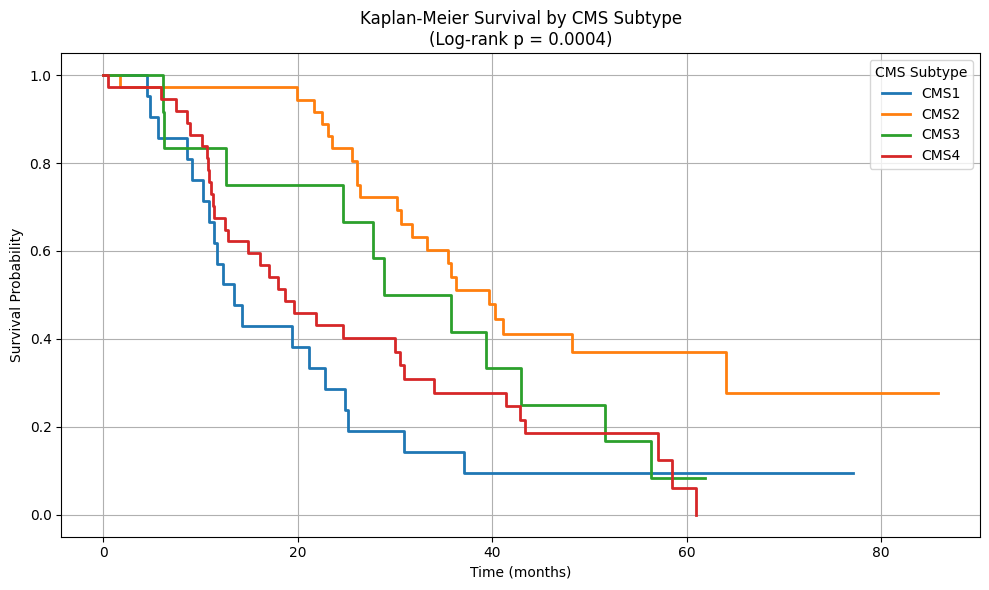

In [6]:
# ---  Kaplan-Meier Plot ---
plt.figure(figsize=(10,6))
kmf = KaplanMeierFitter()

median_survivals = []

for cms in sorted(km_df['CMS'].unique()):
    mask = km_df['CMS'] == cms
    kmf.fit(
        durations=km_df.loc[mask, 'survival_time'],
        event_observed=km_df.loc[mask, 'event'],
        label=cms
    )
    kmf.plot_survival_function(ci_show=False, linewidth=2)

    # Get median survival and CI
    median_ = kmf.median_survival_time_

    # lifelines stores CI for survival curve, not directly for the median,
    # but we can approximate it by inverting the survival function.
    try:
        ci_low = kmf.confidence_interval_survival_function_.iloc[:, 1]  # upper bound
        ci_high = kmf.confidence_interval_survival_function_.iloc[:, 0]  # lower bound

        # Find where CI curves cross 0.5
        lower_ci_time = ci_low[ci_low <= 0.5].index.min()
        upper_ci_time = ci_high[ci_high <= 0.5].index.min()
    except Exception:
        lower_ci_time, upper_ci_time = np.nan, np.nan

    median_survivals.append({
        'CMS': cms,
        'Median Survival (months)': median_,
        '95% CI Lower (approx)': lower_ci_time,
        '95% CI Upper (approx)': upper_ci_time
    })

# --- 4. Log-rank test ---
results = multivariate_logrank_test(
    km_df['survival_time'],
    km_df['CMS'],
    event_observed=km_df['event']
)
p_value = results.p_value

# --- 5. Plot formatting ---
plt.title(f"Kaplan-Meier Survival by CMS Subtype\n(Log-rank p = {p_value:.4f})")
plt.xlabel("Time (months)")
plt.ylabel("Survival Probability")
plt.legend(title='CMS Subtype')
plt.grid(True)
plt.tight_layout()
plt.show()

## Median OS with 95% Confidence Intervals

In [7]:
median_df = pd.DataFrame(median_survivals)
print("Median Survival Times by CMS (with CI):")
display(median_df)
# Optional: Save to file
median_df.to_csv("output/median_survival_by_CMS.csv", index=False)

Median Survival Times by CMS (with CI):


,CMS,Median Survival (months),95% CI Lower (approx),95% CI Upper (approx)
0,CMS1,13.458795,22.814299,10.274641
1,CMS2,39.687032,64.076995,30.594139
2,CMS3,28.887170,51.570163,6.269829
3,CMS4,18.743834,30.528486,12.539658


# Kaplan-Meier Analysis for Progression-Free Survival (PFS)

### Prepare data

In [8]:
pfs_df = ann[['CMS_predicted', 'PFS', 'PFS_FLAG']].dropna()

pfs_df = pfs_df.rename(columns={
    'CMS_predicted': 'CMS',
    'PFS': 'survival_time',
    'PFS_FLAG': 'event'
})
pfs_df['survival_time'] = pfs_df['survival_time'] / 30.44

pfs_df['CMS_clean'] = pfs_df['CMS'].str.strip().str.lower()
pfs_df = pfs_df[pfs_df['CMS_clean'] != 'unc']
pfs_df['CMS'] = pfs_df['CMS'].str.strip()

### Kaplan-Meier Plot + Log-Rank Test

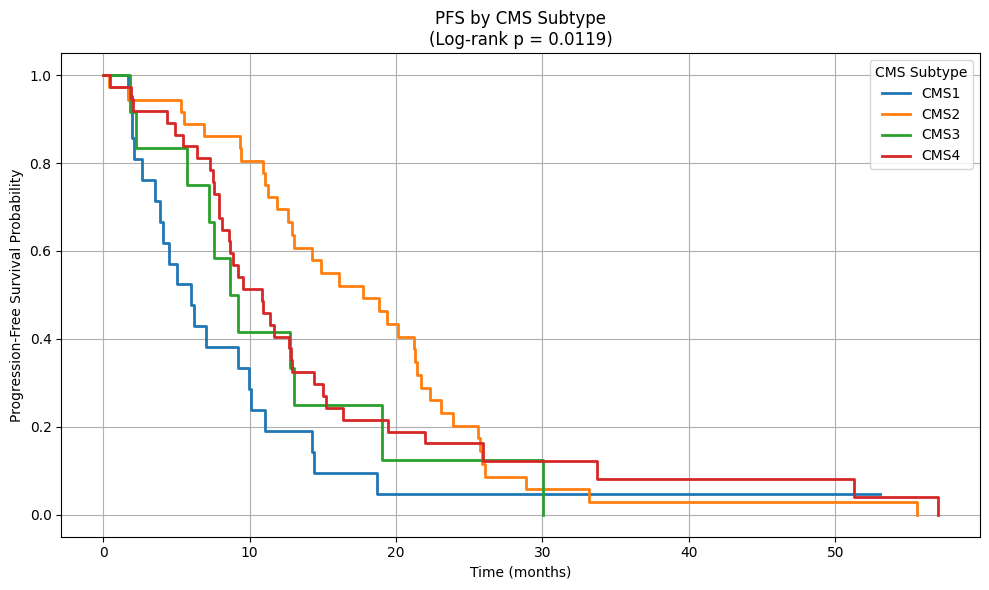

In [10]:
plt.figure(figsize=(10,6))
kmf = KaplanMeierFitter()

for cms in sorted(pfs_df['CMS'].unique()):
    mask = pfs_df['CMS'] == cms
    kmf.fit(
        durations=pfs_df.loc[mask, 'survival_time'],
        event_observed=pfs_df.loc[mask, 'event'],
        label=cms
    )
    kmf.plot_survival_function(ci_show=False, linewidth=2)

results = multivariate_logrank_test(
    pfs_df['survival_time'],
    pfs_df['CMS'],
    event_observed=pfs_df['event']
)
p_value = results.p_value

plt.title(f"PFS by CMS Subtype\n(Log-rank p = {p_value:.4f})")
plt.xlabel("Time (months)")
plt.ylabel("Progression-Free Survival Probability")
plt.legend(title='CMS Subtype')
plt.grid(True)
plt.tight_layout()
plt.show()


### Median PFS with 95% Confidence Intervals

,CMS,Median PFS (months),95% CI Lower (approx),95% CI Upper (approx)
0,CMS1,5.974392,9.979204,3.545244
1,CMS2,17.726218,21.402767,12.638137
2,CMS3,8.666151,19.039271,2.232190
3,CMS4,10.865515,12.900747,8.108103


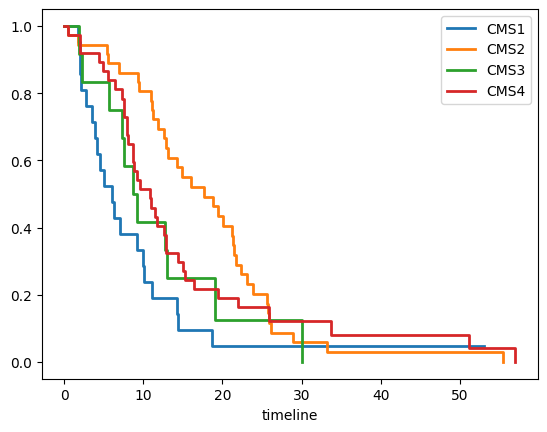

In [13]:
median_survivals_pfs = []

for cms in sorted(pfs_df['CMS'].unique()):
    mask = pfs_df['CMS'] == cms
    kmf.fit(
        durations=pfs_df.loc[mask, 'survival_time'],
        event_observed=pfs_df.loc[mask, 'event'],
        label=cms
    )
    kmf.plot_survival_function(ci_show=False, linewidth=2)

    median_ = kmf.median_survival_time_

    try:
        ci_low = kmf.confidence_interval_survival_function_.iloc[:, 1]
        ci_high = kmf.confidence_interval_survival_function_.iloc[:, 0]

        lower_ci_time = ci_low[ci_low <= 0.5].index.min()
        upper_ci_time = ci_high[ci_high <= 0.5].index.min()
    except Exception:
        lower_ci_time, upper_ci_time = np.nan, np.nan

    median_survivals_pfs.append({
        'CMS': cms,
        'Median PFS (months)': median_,
        '95% CI Lower (approx)': lower_ci_time,
        '95% CI Upper (approx)': upper_ci_time
    })

median_pfs_df = pd.DataFrame(median_survivals_pfs)
display(median_pfs_df)
median_pfs_df.to_csv("output/median_pfs_by_CMS.csv", index=False)
